In [1]:
from datetime import datetime
import logging

logging.basicConfig(filename='train_initialization.log', filemode='w', format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S', level=logging.INFO)
logging.info('SCRIPT INICIADO')


In [2]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import clear_session
from keras.optimizers import SGD
from pathlib import Path
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D
from keras import initializers, regularizers

logging.info('BIBLIOTECAS IMPORTADAS')

In [3]:
# reusable stuff
import constants
import callbacks
import generators

logging.info('CONFIGURAÇÕES IMPORTADAS')

In [4]:
# No kruft plz
clear_session()
logging.info('SESSÃO REINICIALIZADA COM SUCESSO')

import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session

config = tf.compat.v1.ConfigProto() 
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
sess = tf.compat.v1.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

logging.info('AJUSTES DE USO DE GPU FINALIZADO COM SUCESSO')

In [5]:
# Config
height = constants.SIZES['basic']
width = height
weights_file = "weights.best_mobilenet" + str(height) + ".hdf5"

logging.info('PESOS DO MODELO IMPORTADOS COM SUCESSO')

In [6]:
conv_base = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(height, width, constants.NUM_CHANNELS)
)
logging.info('MODELO MobileNetV2 IMPORTADO COM SUCESSO')

9412608/9406464 [==============================] - 1s 0us/step


In [7]:
# First time run, no unlocking
conv_base.trainable = False
logging.info('AJUSTE DE TREINAMENTO DO MODELO REALIZADO COM SUCESSO')

In [8]:
# Let's see it
print('Summary')
print(conv_base.summary())

logging.info('SUMARIO DO MODELO')
logging.info(conv_base.summary())

Summary
Model: &quot;mobilenetv2_1.00_224&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_____________________________________________________________

In [9]:
# Let's construct that top layer replacement
x = conv_base.output
x = AveragePooling2D(pool_size=(7, 7))(x)
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_initializer=initializers.he_normal(seed=None), kernel_regularizer=regularizers.l2(.0005))(x)
x = Dropout(0.5)(x)
# Essential to have another layer for better accuracy
x = Dense(128,activation='relu', kernel_initializer=initializers.he_normal(seed=None))(x)
x = Dropout(0.25)(x)
predictions = Dense(constants.NUM_CLASSES,  kernel_initializer="glorot_uniform", activation='softmax')(x)

logging.info('NOVAS CAMADAS CONFIGURADAS COM SUCESSO')

In [10]:
print('Stacking New Layers')
model = Model(inputs = conv_base.input, outputs=predictions)

logging.info('NOVAS CAMADAS ADICIONADAS AO MODELO COM SUCESSO')

Stacking New Layers


In [11]:
# Load checkpoint if one is found
if os.path.exists(weights_file):
        print ("loading ", weights_file)
        model.load_weights(weights_file)

logging.info('VERIFICAÇÃO DE CHECKPOINT')

In [12]:
# Get all model callbacks
callbacks_list = callbacks.make_callbacks(weights_file)

logging.info('INICIALIZACAO DO CALLBACK REALIZADO')

In [13]:
print('Compile model')
# originally adam, but research says SGD with scheduler
# opt = Adam(lr=0.001, amsgrad=True)
opt = SGD(momentum=.9)
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

logging.info('MODELO COMPILADO COM SUCESSO')

Compile model


In [14]:
# Get training/validation data via generators
train_generator, validation_generator = generators.create_generators(height, width)

logging.info('BASES DE TREINAMENTO E TESTES IMPORTADAS COM SUCESSO')

Found 55000 images belonging to 2 classes.
Found 8500 images belonging to 2 classes.


In [15]:
print('Start training!')

logging.info('TREINAMENTO DO MODELO INICIADO')

history = model.fit_generator(
    train_generator,
    callbacks=callbacks_list,
    epochs=constants.TOTAL_EPOCHS,
    steps_per_epoch=constants.STEPS_PER_EPOCH,
    shuffle=True,
    workers=4,
    use_multiprocessing=False,
    validation_data=validation_generator,
    validation_steps=constants.VALIDATION_STEPS
)
logging.info('TREINAMENTO DO MODELO FINALIZADO')

Start training!
Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 1.5425 - accuracy: 0.5279
Epoch 00001: val_accuracy improved from -inf to 0.57313, saving model to weights.best_mobilenet224.hdf5
500/500 [==============================] - 75s 151ms/step - loss: 1.5425 - accuracy: 0.5279 - val_loss: 0.9690 - val_accuracy: 0.5731
Epoch 2/100
500/500 [==============================] - ETA: 0s - loss: 1.2637 - accuracy: 0.5212
Epoch 00002: val_accuracy improved from 0.57313 to 0.57875, saving model to weights.best_mobilenet224.hdf5
500/500 [==============================] - 75s 151ms/step - loss: 1.2637 - accuracy: 0.5212 - val_loss: 0.9530 - val_accuracy: 0.5788
Epoch 3/100
500/500 [==============================] - ETA: 0s - loss: 1.1816 - accuracy: 0.5307
Epoch 00003: val_accuracy improved from 0.57875 to 0.58125, saving model to weights.best_mobilenet224.hdf5
500/500 [==============================] - 73s 147ms/step - loss: 1.1816 - accuracy: 0.5307 - val_loss: 0.9

In [16]:
# Save it for later
print('Saving Model')
model.save("nude_mobilenet2." + str(width) + "x" + str(height) + ".h5")
logging.info('MODELO EXPORTADO COM SUCESSO')

Saving Model


In [17]:
final_loss, final_accuracy = model.evaluate(validation_generator, steps = constants.VALIDATION_STEPS)
logging.info('AVALIACAO DO MODELO REALIZADO COM SUCESSO')


50/50 [==============================] - 5s 93ms/step - loss: 0.4125 - accuracy: 0.8881


In [18]:
print("Final loss: {:.2f}".format(final_loss))
print("Final accuracy: {:.2f}%".format(final_accuracy * 100))

logging.info('FINAL LOSS: {:.2f}'.format(final_loss))
logging.info('FINAL ACCURACY: {:.2f}%'.format(final_accuracy * 100))

Final loss: 0.41
Final accuracy: 88.81%


In [19]:
import matplotlib.pyplot as plt

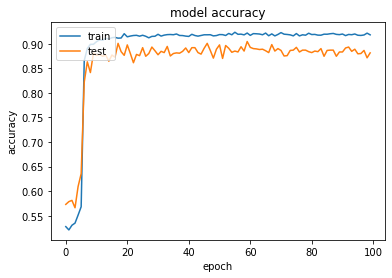

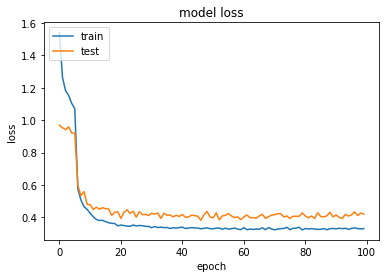

In [20]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
saved_model_dir = 'nude_mobilenetv2_train'
Path(saved_model_dir).mkdir(parents=True, exist_ok=True)
tf.saved_model.save(model, saved_model_dir)
keras_model_path = os.path.join(saved_model_dir, "saved_model.h5")
weights_path = os.path.join(saved_model_dir, "saved_model_weights.h5")
model.save(keras_model_path)
model.save_weights(weights_path)
print("SavedModel model exported to", saved_model_dir)
logging.info('MODELO SALVO NA PASTA %s', saved_model_dir)

SavedModel model exported to nude_mobilenetv2_train


In [23]:
indexed_labels = [(index, label) for label, index in train_generator.class_indices.items()]
print(indexed_labels)
logging.info('LABELS: %s', indexed_labels)

[(0, &#39;not_safe&#39;), (1, &#39;safest&#39;)]


In [24]:
sorted_indices, sorted_labels = zip(*sorted(indexed_labels))
print(sorted_indices)
print(sorted_labels)

logging.info('SORTED INDICES: %s', sorted_indices)
logging.info('SORTED LABELS: %s', sorted_labels)


(0, 1)
(&#39;not_safe&#39;, &#39;safest&#39;)


In [25]:
labels_dir_path = os.path.dirname(saved_model_dir)
# Ensure dir structure exists
Path(saved_model_dir).mkdir(parents=True, exist_ok=True)
with tf.io.gfile.GFile('labels.txt', "w") as f:
    f.write("\n".join(sorted_labels + ("",)))
print("Labels written to", saved_model_dir)
logging.info('ARQUIVO DE LABELS SALVO COM SUCESSO')

Labels written to nude_mobilenetv2_train


In [26]:
model.summary()

Model: &quot;functional_1&quot;
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_____________________________________________________________________________